In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_06 import *

# Get data

In [3]:
x_train,y_train,x_valid,y_valid= get_data_normalized()

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [109]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [110]:
nh,bs,c

(50, 512, 10)

In [6]:
mnist_view = view_tfm(1,28,28) # 2d array to 3d imgs func
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [7]:
nfs = [8,16,32,64,64]
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
%time run.fit(2, learn)

train: [0.9809075520833334, tensor(0.6786, device='cuda:0')]
valid: [0.9643482421875, tensor(0.7166, device='cuda:0')]
train: [0.2806949544270833, tensor(0.9110, device='cuda:0')]
valid: [0.86595380859375, tensor(0.7420, device='cuda:0')]
CPU times: user 3.1 s, sys: 783 ms, total: 3.88 s
Wall time: 4.45 s


# Batchnorm

In [10]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        
        #declare trainable parameters for batchnorm
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # shape: (channels,1,1)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1)) # this is identical to nn.Linear bias, thus we don't need to use bias when using batchnorm
        
        # exponentially moving avg variables
        
        # use register_buffer to move anything in buffer to GPU
        # Also register_buffer will be included in backprop
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) 
        self.register_buffer('means', torch.zeros(1,nf,1,1)) 

    def update_stats(self, x): # shape: (bs,channels,h,w)
        m = x.mean((0,2,3), keepdim=True) # shape: (1,channels,1,1)
        v = x.var ((0,2,3), keepdim=True)
        
        # keep an exponentially moving avg of x.mean and x.var IN TRAINING (not in inference)
        self.means.lerp_(m, self.mom) # aka linear interpolation
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: 
            #in inference time, we will just take the running mean and var so-far (WITHOUT UPDATING THEM)
            m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [11]:
# conv layer with batchnorm: nn.Sequential(conv2d -> generalRELU -> bn)
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [12]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

In [13]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

# Start training with bn

In [14]:
nfs

[8, 16, 32, 64, 64]

In [ ]:
??append_stats

In [15]:
learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs)

train: [0.44374189453125, tensor(0.8602, device='cuda:0')]
valid: [0.70339189453125, tensor(0.7876, device='cuda:0')]
train: [0.18303160807291666, tensor(0.9443, device='cuda:0')]
valid: [0.6751859375, tensor(0.7934, device='cuda:0')]


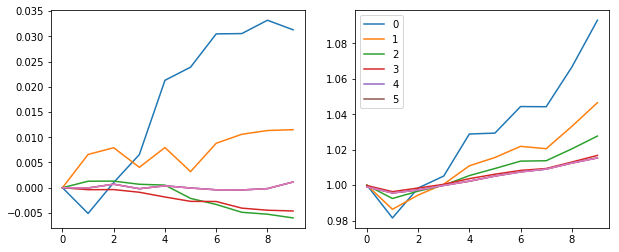

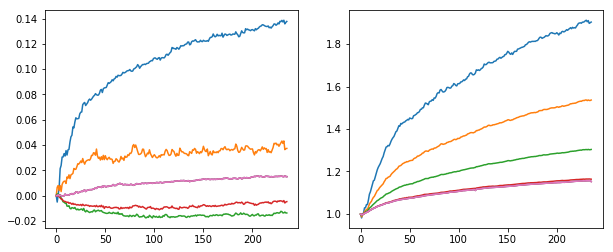

In [16]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

Previous training with kaiming init and general RELU

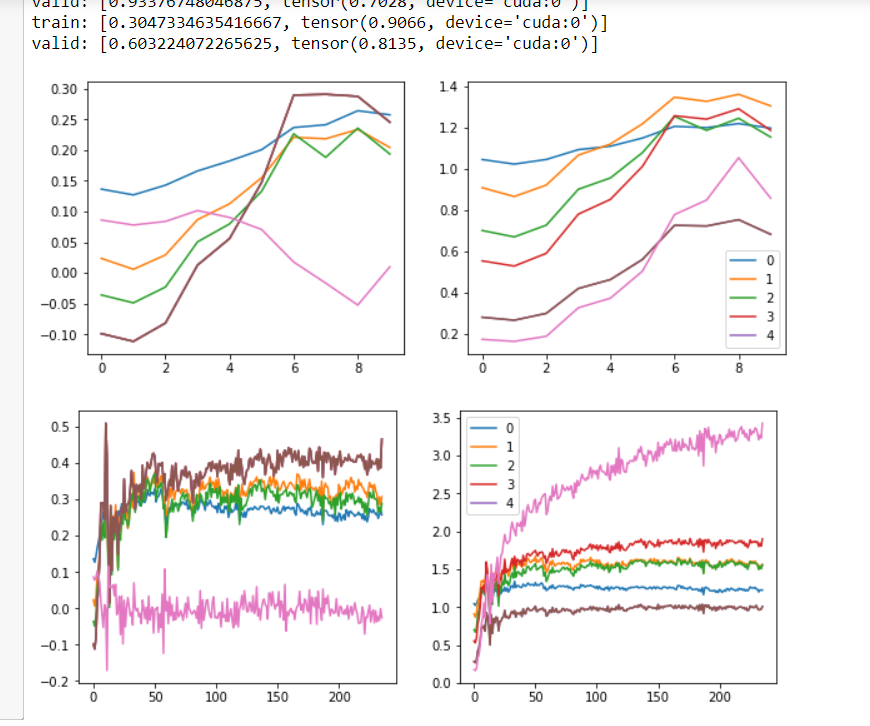

Activations mean and std are closer to 0 and 1, respectively. There is no 'jump' in mean and std for long training

We can now train with high lr and still have good results (probably due to bn smoothens the loss landscape)

In [17]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)
%time run.fit(3, learn)

train: [0.41578570963541667, tensor(0.8692, device='cuda:0')]
valid: [0.88095576171875, tensor(0.7350, device='cuda:0')]
train: [0.1647373046875, tensor(0.9493, device='cuda:0')]
valid: [0.43964609375, tensor(0.8602, device='cuda:0')]
train: [0.11591859537760417, tensor(0.9645, device='cuda:0')]
valid: [0.435776953125, tensor(0.8694, device='cuda:0')]
CPU times: user 3.27 s, sys: 371 ms, total: 3.64 s
Wall time: 3.65 s


# Using pytorch batchnorm

In [18]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [19]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [20]:
%time run.fit(3, learn)

train: [0.44951692708333335, tensor(0.8590, device='cuda:0')]
valid: [1.2799416015625, tensor(0.6848, device='cuda:0')]
train: [0.15255328776041666, tensor(0.9537, device='cuda:0')]
valid: [0.56404287109375, tensor(0.8289, device='cuda:0')]
train: [0.10384156901041666, tensor(0.9685, device='cuda:0')]
valid: [0.52366552734375, tensor(0.8422, device='cuda:0')]
CPU times: user 2.97 s, sys: 408 ms, total: 3.38 s
Wall time: 3.39 s


# Full training with bn

In [21]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [22]:
run.fit(8, learn)

train: [0.45154645182291664, tensor(0.8634, device='cuda:0')]
valid: [1.03400810546875, tensor(0.7118, device='cuda:0')]
train: [0.17093033854166667, tensor(0.9474, device='cuda:0')]
valid: [1.22511689453125, tensor(0.6888, device='cuda:0')]
train: [0.14628225911458334, tensor(0.9551, device='cuda:0')]
valid: [0.297266064453125, tensor(0.9105, device='cuda:0')]
train: [0.07070951334635417, tensor(0.9778, device='cuda:0')]
valid: [0.3835445556640625, tensor(0.8921, device='cuda:0')]
train: [0.0466947265625, tensor(0.9859, device='cuda:0')]
valid: [0.257787841796875, tensor(0.9303, device='cuda:0')]
train: [0.030294671630859374, tensor(0.9916, device='cuda:0')]
valid: [0.2306947021484375, tensor(0.9394, device='cuda:0')]
train: [0.020599228922526042, tensor(0.9946, device='cuda:0')]
valid: [0.2362421875, tensor(0.9399, device='cuda:0')]
train: [0.014214285278320313, tensor(0.9971, device='cuda:0')]
valid: [0.2299951171875, tensor(0.9415, device='cuda:0')]


## Problem with batchnorm

In [23]:
torch.Tensor([2]).mean(),torch.Tensor([2]).var()

(tensor(2.), tensor(nan))

In [24]:
torch.Tensor([2.01,2.02]).mean(),torch.Tensor([2.01,2.02]).var()

(tensor(2.0150), tensor(5.0000e-05))

### 1. Cannot apply model with bn to 'online learning task' where the batch size has to be small (only 1 or 2 items can be fed at a time)

Var of batch with 1 item is 0. For 2 items,  it would be very small if these 2 images are similar 

-> x_updated = x-mean/(sqrt(var+ep)) will be huge -> mess up our training


### 2. Also batchnorm cannot be used for RNN when we reuse our weight matrices for learning in order to have predict n words-> we can't just put a batchnorm at each activation (for each word) since there could be thousand of these activations (e.g. when predicting next words)

### 3. When calculating mean and std of a batch in batchnorm, we assume that item in batch has the same size (e.g. img with same h,w,channels). In RNN, sentences in a batch can have different length (Although this can be fixed with padding, but by adding padding, it can alter the true meaning of mean and std of that batch)

# Different norm strategy

## layer norm

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

Layer norm formula is essentially the same as batchnorm, but
- No moving average
- Average over the hidden dimension to make the norm strategy **independent of the batch size**

Previous batchnorm code

```python
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # shape: (channels,1,1)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))        
        # exponentially moving avg variables
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) 
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x): # shape: (bs,channels,h,w)
        m = x.mean((0,2,3), keepdim=True) # shape: (1,channels,1,1)
        v = x.var ((0,2,3), keepdim=True)        
        # keep an exponentially moving avg of x.mean and x.var IN TRAINING (not in inference)
        self.means.lerp_(m, self.mom) # aka linear interpolation
        self.vars.lerp_ (v, self.mom)
        return m,v        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds
```

In [25]:
torch.randn((5,3,2,2)).mean((1,2,3), keepdim=True).shape

torch.Size([5, 1, 1, 1])

In [26]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        # We don't use exp moving avg here because each img now has its own mean and std. Each img can take care of itself 
        # In batchnorm, mean and std are calculated **across a batch** containing multiple imgs, thus we need exp moving avg
        # to smoothen them out
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True) # shape: (bs,1,1,1). Taking the mean of each image in batch individually
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

## Downside of layer norm

There is no running avg at inference time (note that running avg represents the mean and std of a whole dataset).

There is no different normalization at each channel



In [27]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [31]:

learn,run = get_learn_run(nfs, data, 0.9, conv_ln, cbs=cbfs)

%time run.fit(3, learn)

train: [0.5371201822916667, tensor(0.8267, device='cuda:0')]
valid: [0.78496513671875, tensor(0.7714, device='cuda:0')]
train: [0.15201873372395833, tensor(0.9531, device='cuda:0')]
valid: [0.644924560546875, tensor(0.8353, device='cuda:0')]
train: [0.09338758951822916, tensor(0.9708, device='cuda:0')]
valid: [0.3878290283203125, tensor(0.8954, device='cuda:0')]
CPU times: user 3.92 s, sys: 364 ms, total: 4.28 s
Wall time: 4.29 s


In [32]:
# cannot be trained with high learning rate
learn,run = get_learn_run(nfs, data, 1, conv_ln, cbs=cbfs)

%time run.fit(3, learn)

train: [nan, tensor(0.1237, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
CPU times: user 3.92 s, sys: 400 ms, total: 4.32 s
Wall time: 4.33 s


One example that would make layernorm model fail to train: sunny day vs foggy day (where variances are very different from each other). However when you normalize them individually, they will turn out to be similar. 

Note that **when normalizing a distribution, you ignore the original scale (by converting into mean 0), and variance (by converting into std 1)**: e.g. foggy pictures have more gray pixels with low variances. Sunny picture have bright pixels with high variance. Normalizing them individually will remove these 2 characteristics of the image, thus throw away the difference (variance) in the activation


In [63]:
temp=torch.FloatTensor(1000).uniform_(100,200)

temp.mean(),temp.std()

(tensor(148.7700), tensor(28.7567))

In [64]:
temp_norm=(temp-temp.mean()) /temp.std()

temp_norm.mean(),temp_norm.std()

(tensor(-1.2696e-07), tensor(1.))

### Using layer norm

<img src="sunny_foggy_layernorm.PNG">


### Using batchnorm


<img src="sunny_foggy_batchnorm.PNG">

# Instance norm

Normalize each channels of each image in batch, individually

In [34]:
torch.randn((5,3,2,2)).mean((2,3), keepdim=True).shape

torch.Size([5, 3, 1, 1])

In [33]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [35]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [39]:
learn,run = get_learn_run(nfs, data, 0.001, conv_in, cbs=cbfs)
%time run.fit(3, learn)

train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
CPU times: user 3.85 s, sys: 400 ms, total: 4.25 s
Wall time: 4.26 s


In [40]:
learn,run = get_learn_run(nfs, data, 1, conv_in, cbs=cbfs)
%time run.fit(3, learn)

train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
train: [nan, tensor(0.1000, device='cuda:0')]
valid: [nan, tensor(0.1000, device='cuda:0')]
CPU times: user 3.81 s, sys: 420 ms, total: 4.23 s
Wall time: 4.23 s


(array([ 99.,  98., 102.,  88.,  90., 118.,  93., 108.,  93., 111.]),
 array([100.12829 , 110.093735, 120.05919 , 130.02463 , 139.99008 , 149.95554 , 159.92097 , 169.88643 , 179.85188 ,
        189.81732 , 199.78278 ], dtype=float32),
 <a list of 10 Patch objects>)

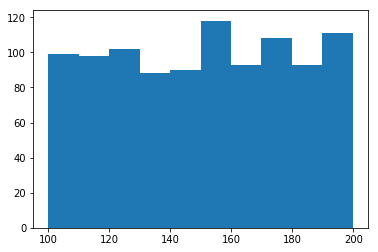

In [58]:
temp=torch.FloatTensor(1000).uniform_(100,200)
plt.hist(temp)

(array([ 99.,  98., 102.,  88.,  90., 118.,  93., 108.,  93., 111.]),
 array([-1.744263, -1.399957, -1.055651, -0.711344, -0.367038, -0.022732,  0.321574,  0.66588 ,  1.010187,  1.354493,
         1.698799], dtype=float32),
 <a list of 10 Patch objects>)

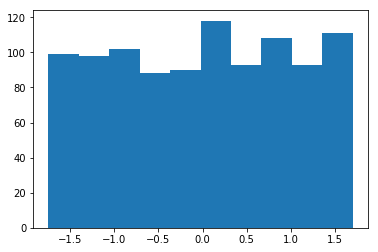

In [59]:
plt.hist( (temp-temp.mean()) /temp.std())

In [60]:
temp.mean(),temp.std()

(tensor(150.6135), tensor(28.9436))

In [61]:
temp_norm=(temp-temp.mean()) /temp.std()

In [62]:
temp_norm.mean(),temp_norm.std()

(tensor(-2.4641e-07), tensor(1.))

Not doing well because we make a similar mistake as layer norm: instead of taking away the mean and std of a whole img, we are taking away mean and std of each channel of the image. **This is worst since now we throw away mean and std in a deeper level**: for each image, we essentially make these 3 different color channels to vary in the same way, taking away unique characteristics

Note that **instance norm are not designed for classification**. This is for style transfer: where the differences in contrast (or just overall amount) b/t channels are not important so they can be removed 

# Fix small batchsize problem, Jeremy's style

In [65]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [66]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

Training with small batchsize

In [67]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [68]:
%time run.fit(1, learn) #

train: [2.3468466145833333, tensor(0.1785, device='cuda:0')]
valid: [3.1001958984375, tensor(0.1974, device='cuda:0')]
CPU times: user 1min 28s, sys: 695 ms, total: 1min 29s
Wall time: 1min 29s


## Running batchnorm

Previous batchnorm code

```python
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1)) # shape: (channels,1,1)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))        
        # exponentially moving avg variables
        
        # PROBLEM:  why do we take running avg of variances? It does not make sense to 'average' bunch of variances
        self.register_buffer('vars',  torch.ones(1,nf,1,1)) 
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x): # shape: (bs,channels,h,w)
        m = x.mean((0,2,3), keepdim=True) # shape: (1,channels,1,1)
        v = x.var ((0,2,3), keepdim=True)        
        # keep an exponentially moving avg of x.mean and x.var IN TRAINING (not in inference)
        self.means.lerp_(m, self.mom) # aka linear interpolation
        self.vars.lerp_ (v, self.mom)
        return m,v        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
            
        #PROBLEM WITH SMALL SIZE BATCHNORM LIES HERE:
        # We use the current batch mean m and var v to normalize x here, and small bs causes v to be small (~0)
        # This can be partly fixed with setting self.eps to be bigger
        # What if we don't use current batch m and v for this, but using some running average values?
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds
```

In [70]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        
        # We will calculate variance the other way: E[X^2] - (E[X])^2, or 'sums' - 'sqrs' 
        # With this method, we can calculate variance on the fly (without storing running avg of the variance itself which does not make sense)
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        
        #  since batch size does not have to be the same for every batch, we keep:
        # moving avg count:  keep track of # of numbers stored in a batch (ignoring channels). 
        # E.g.: for 64,3,224,224, count = 64*224*224. Since we cal sums and sqrs, we need this to calculate mean
        self.register_buffer('count', tensor(0.))
        
        # batch: keep cum count for bs; keep count of # of images processed sofar
        self.register_buffer('batch', tensor(0.))
        # step: # of iterations/ # of processed batches
        self.register_buffer('step', tensor(0.))
        
        # this is the same thing as Andrew Ng bias correction
        # divide the weight average by (1- mom**ite)
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        
        s = x.sum(dims, keepdim=True) # cal sum(X) for E[X]. Shape (1,channels,1,1)
        ss = (x*x).sum(dims, keepdim=True) # cal sum(X^2) for E[X^2]. Shape (1,channels,1,1)
        c = self.count.new_tensor(x.numel()/nc) # number of items used for s and ss
        # tensor.new_tensor(data) return the tensor with same device and type, but with new input data
        
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)        
        self.mom1 = self.dbias.new_tensor(mom1)
        
        #running avg for sum(X) and sumsquare(X)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        # stop doing bias correction when # of batches >=100
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c # mean(X), or E[X]
        vars = (sqrs/c).sub_(means*means) # sum(X^2)/c - mean(X)^2
        
        if bool(self.batch < 20): vars.clamp_min_(0.01) # if # of imgs so far is <20 (first few batches with small bs?), 
            # make sure var is not too close to 0
        # when bs is small and self.batch >20, we don't need to worry anymore 
        # since we are now using running avg variables to calculate var
        
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [73]:
nfs

[8, 16, 32, 64, 64]

In [74]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [75]:

learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [76]:
%time run.fit(1, learn)

train: [0.8083244140625, tensor(0.7860, device='cuda:0')]
valid: [1.58296943359375, tensor(0.7984, device='cuda:0')]
CPU times: user 3min 45s, sys: 1.47 s, total: 3min 46s
Wall time: 3min 47s


## Running bn rewrite

It turns out we don't actually need to debias - because, for instance, dividing a debiased sum by a debiased count is the same as dividing a biased sum by a biased count! So we can remove all the debiasing stuff and end up with a simpler class

Also, we should save eps as a buffer since it impacts the calculation. (Thanks to Stas Bekman for noticing these.) Also we can slightly change the final calculation in forward with one that uses factor and offset to reduce the amount of broadcasting required. (Thanks to Tom Viehmann for this suggestion.)

In [103]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_() # change require_grad to False
        self.sqrs.detach_() # detach() gradient computation is guaranteed to be correct
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums .lerp_(s , mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c , mom1)
        self.batch += bs
        
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset

In [104]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

# Best single run for 1 epoch

## Running bn

In [105]:
nfs

[8, 16, 32, 64, 64]

In [106]:
cbfs

[exp.nb_05b.Recorder,
 functools.partial(<class 'exp.nb_05b.AvgStatsCallback'>, <function accuracy at 0x7fe918801d90>),
 exp.nb_06.CudaCallback,
 functools.partial(<class 'exp.nb_06.BatchTransformXCallback'>, <function view_tfm.<locals>._inner at 0x7fe9188016a8>)]

In [119]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.1))])

In [120]:
%time run.fit(1, learn)

train: [0.2707776529947917, tensor(0.9161, device='cuda:0')]
valid: [0.3633769775390625, tensor(0.8990, device='cuda:0')]
CPU times: user 13.7 s, sys: 60.3 ms, total: 13.7 s
Wall time: 13.8 s


In [83]:
# %time run.fit(1, learn)

train: [0.12554662272135417, tensor(0.9620, device='cuda:0')]
valid: [0.2609739501953125, tensor(0.9270, device='cuda:0')]
CPU times: user 14.4 s, sys: 112 ms, total: 14.5 s
Wall time: 14.6 s


In [121]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

learn,run = get_learn_run(nfs, data, 0.8, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [122]:
%time run.fit(1, learn)

train: [0.29564052734375, tensor(0.9087, device='cuda:0')]
valid: [0.2777277587890625, tensor(0.9196, device='cuda:0')]
CPU times: user 14 s, sys: 141 ms, total: 14.1 s
Wall time: 14.2 s


In [118]:
# %time run.fit(1, learn)

train: [0.2923259765625, tensor(0.9104, device='cuda:0')]
valid: [0.3288905517578125, tensor(0.9122, device='cuda:0')]
CPU times: user 13.9 s, sys: 91.8 ms, total: 14 s
Wall time: 14.1 s


In [93]:
# %time run.fit(1, learn)

train: [0.29434166666666667, tensor(0.9102, device='cuda:0')]
valid: [0.2982480712890625, tensor(0.9121, device='cuda:0')]
CPU times: user 14.6 s, sys: 75.8 ms, total: 14.7 s
Wall time: 14.7 s


## batchnorm

In [91]:

data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.1))])

%time run.fit(1, learn)

train: [0.28670009765625, tensor(0.9096, device='cuda:0')]
valid: [0.2867478759765625, tensor(0.9132, device='cuda:0')]
CPU times: user 5.83 s, sys: 61.4 ms, total: 5.89 s
Wall time: 5.92 s


In [124]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

%time run.fit(1, learn)

train: [0.32185546875, tensor(0.9005, device='cuda:0')]
valid: [0.2715822998046875, tensor(0.9184, device='cuda:0')]
CPU times: user 6.07 s, sys: 65.3 ms, total: 6.13 s
Wall time: 6.16 s
